<div style="text-align: center;">
    <h1> <font style="bold"> Trabajo Práctico 3 </font></h1>
    <h2><font style="bold">Visión por Computadora 1 - CEIA </font></h2>
    <h3><font style="bold">Abril Noguera - Pablo Brahim - Kevin Pennington</font></h3>
</div>

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template

1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos

2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1

3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes. Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.

In [36]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
from math import ceil

In [27]:
# Rutas de las imágenes y template
images_path = 'images/'
template_path = 'template/pattern.png'

### Análisis Exploratorio de Datos (EDA) de las Imágenes

En esta sección analizaremos las imágenes disponibles y el template para entender sus características y planificar el preprocesamiento necesario.

In [40]:
# Cargar template
template = cv.imread(template_path)
template_gray = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
template_rgb = cv.cvtColor(template, cv.COLOR_BGR2RGB)
t_h, t_w = template_gray.shape[:2]

print(f"Template: {template_path}")
print(f" - Dimensiones: {t_w}x{t_h}")
print(f" - Canales: {template.shape[2]}")
print(f" - Ratio: {t_w/t_h:.2f}")


Template: template/pattern.png
 - Dimensiones: 400x175
 - Canales: 3
 - Ratio: 2.29


In [33]:
# Lista de imágenes
image_files = sorted(glob.glob(os.path.join(images_path, '*.png')) +
                     glob.glob(os.path.join(images_path, '*.jpg')))

info_list = []

# Analizar imágenes
for img_path in image_files:
    img = cv.imread(img_path)
    if img is None:
        continue
    h, w = img.shape[:2]
    c = img.shape[2] if len(img.shape) > 2 else 1
    size_mb = os.path.getsize(img_path) / (1024*1024)
    
    info_list.append({
        "name": os.path.basename(img_path),
        "width": w,
        "height": h,
        "channels": c,
        "size_mb": size_mb,
        "ratio": w/h
    })
    
    print(f"{os.path.basename(img_path)} - {w}x{h}, {c} canales, "
          f"{size_mb:.2f} MB, ratio={w/h:.2f}")


COCA-COLA-LOGO.jpg - 1389x1389, 3 canales, 0.24 MB, ratio=1.00
coca_logo_1.png - 207x500, 3 canales, 0.14 MB, ratio=0.41
coca_logo_2.png - 233x363, 3 canales, 0.14 MB, ratio=0.64
coca_multi.png - 799x598, 3 canales, 1.03 MB, ratio=1.34
coca_retro_1.png - 715x493, 3 canales, 0.38 MB, ratio=1.45
coca_retro_2.png - 715x429, 3 canales, 0.55 MB, ratio=1.67
logo_1.png - 687x450, 3 canales, 0.48 MB, ratio=1.53


- El template (`400x175 px`, ratio **2.29**) es más ancho que la mayoría de las imágenes.
- Las imágenes presentan **proporciones y tamaños variables** (ratios **0.41–1.67**), algunas más pequeñas y otras más grandes que el template.
- Todas son **RGB**.
- Se requiere **template matching multi-escala** para evitar falsos negativos.

In [51]:
def bgr2rgb(img):  # Clase 1
    return cv.cvtColor(img, cv.COLOR_BGR2RGB)

def to_gray(img_bgr):  # Clase 1
    return cv.cvtColor(img_bgr, cv.COLOR_BGR2GRAY)

def hist_rgb(img_bgr):  # Clase 2
    h = []
    for ch in range(3):
        h.append(cv.calcHist([img_bgr],[ch],None,[256],[0,256]))
    return h  # B,G,R

def otsu(gray):  # Clase 2
    _, th = cv.threshold(gray, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    return th

def clahe(gray): # Clase 2
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(gray)

def gaussian_blur(img, k=5, s=0):  # Clase 3
    return cv.GaussianBlur(img, (k,k), s)

def canny(gray, t1=80, t2=180):  # Clase 3
    return cv.Canny(gray, t1, t2)

def sobel_mag(gray, ksize=3):  # Clase 3
    gx = cv.Sobel(gray, cv.CV_32F, 1, 0, ksize=ksize)
    gy = cv.Sobel(gray, cv.CV_32F, 0, 1, ksize=ksize)
    mag = cv.magnitude(gx, gy)
    # normalizamos a [0,1]
    mag = cv.normalize(mag, None, 0, 1, cv.NORM_MINMAX)
    return mag

def gaussian_pyr(img, levels=4):  # Clase 4 (pirámides)
    pyr = [img]
    for _ in range(levels-1):
        img = cv.pyrDown(img)
        pyr.append(img)
    return pyr

def mask_red_hsv(img_bgr):  # Clase 1
    hsv = cv.cvtColor(img_bgr, cv.COLOR_BGR2HSV)
    # Rojos en dos rangos (envolviendo el 0/180)
    lower1, upper1 = (0, 80, 80), (10, 255, 255)
    lower2, upper2 = (170, 80, 80), (180, 255, 255)
    m1 = cv.inRange(hsv, np.array(lower1), np.array(upper1))
    m2 = cv.inRange(hsv, np.array(lower2), np.array(upper2))
    mask = cv.bitwise_or(m1, m2)
    return mask

def orb_keypoints(gray, n=700):  # Clase 5
    orb = cv.ORB_create(nfeatures=n)
    kp, des = orb.detectAndCompute(gray, None)
    return kp, des

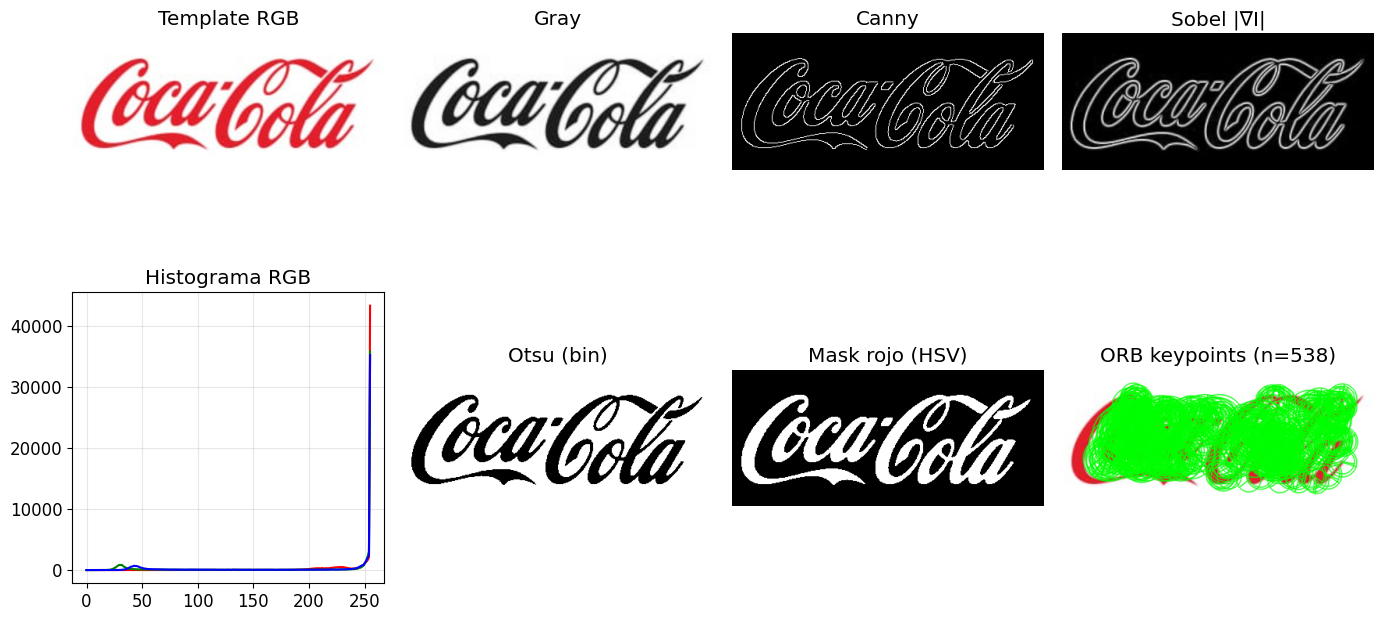

In [52]:
tpl_bgr = cv.imread(template_path)
assert tpl_bgr is not None, f"No se pudo leer {template_path}"
tpl_rgb = bgr2rgb(tpl_bgr)
tpl_gray = to_gray(tpl_bgr)

tpl_blur = gaussian_blur(tpl_gray, 5, 0)
tpl_canny = canny(tpl_blur, 80, 180)
tpl_sobel = sobel_mag(tpl_gray)
tpl_otsu = otsu(tpl_gray)
tpl_mask_red = mask_red_hsv(tpl_bgr)
kp, des = orb_keypoints(tpl_gray)
tpl_kp = cv.drawKeypoints(tpl_rgb, kp, None, color=(0,255,0), flags=cv.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)

pyr = gaussian_pyr(tpl_rgb, 4)
hB, hG, hR = hist_rgb(tpl_bgr)

plt.figure(figsize=(14,10))
plt.subplot(3,4,1);  plt.imshow(tpl_rgb); plt.title("Template RGB"); plt.axis('off')
plt.subplot(3,4,2);  plt.imshow(tpl_gray, cmap='gray'); plt.title("Gray"); plt.axis('off')
plt.subplot(3,4,3);  plt.imshow(tpl_canny, cmap='gray'); plt.title("Canny"); plt.axis('off')
plt.subplot(3,4,4);  plt.imshow(tpl_sobel, cmap='gray'); plt.title("Sobel |∇I|"); plt.axis('off')

plt.subplot(3,4,5);  plt.plot(hR, 'r'); plt.plot(hG, 'g'); plt.plot(hB, 'b')
plt.title("Histograma RGB"); plt.grid(alpha=.3)

plt.subplot(3,4,6);  plt.imshow(tpl_otsu, cmap='gray'); plt.title("Otsu (bin)"); plt.axis('off')
plt.subplot(3,4,7);  plt.imshow(tpl_mask_red, cmap='gray'); plt.title("Mask rojo (HSV)"); plt.axis('off')
plt.subplot(3,4,8);  plt.imshow(tpl_kp); plt.title(f"ORB keypoints (n={len(kp)})"); plt.axis('off')

# for i, lvl in enumerate(pyr, start=1):
#     plt.subplot(3,4,8+i)
#     plt.imshow(lvl); plt.title(f"Pyr L{i-1}: {lvl.shape[1]}x{lvl.shape[0]}")
#     plt.axis('off')

plt.tight_layout()
plt.show()


- El histograma RGB muestra predominancia del rojo, útil para filtrado en HSV, aunque no debe ser el único criterio por posibles casos B/N o desaturados.
- En Gray y con binarización Otsu, la silueta del logo es clara, permitiendo detección sin depender del color.
- Los bordes con Canny y, sobre todo, con Sobel son bien definidos, ideales para template matching robusto a variaciones de iluminación.
- La máscara roja (HSV) aísla el logo en condiciones normales, pero puede fallar con variaciones de color.
- ORB detecta numerosos puntos clave, habilitando matching por características como complemento.

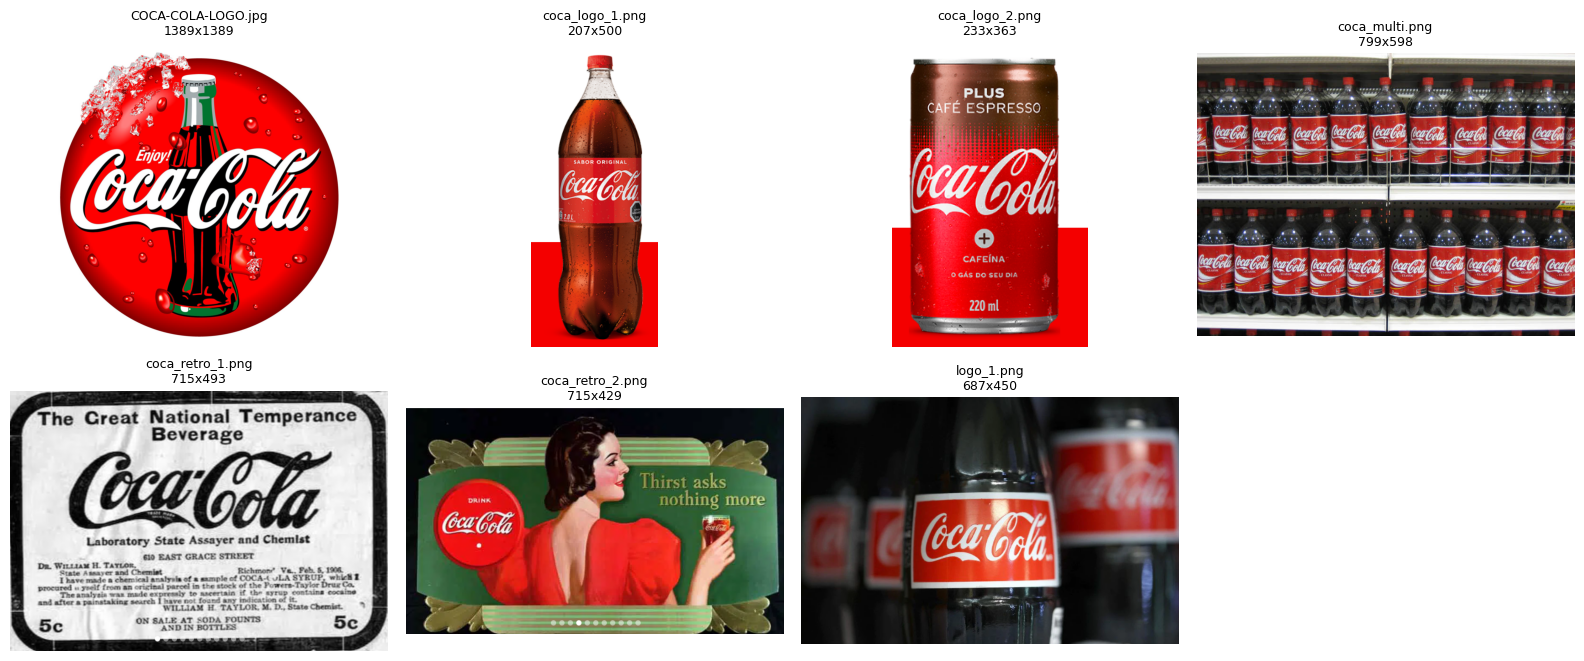

In [48]:
files = sorted(glob.glob(os.path.join(images_path, '*.png')) +
               glob.glob(os.path.join(images_path, '*.jpg')))

n = len(files)
cols = 4
rows = ceil(n/cols)
plt.figure(figsize=(4*cols, 3.5*rows))
for i, p in enumerate(files, start=1):
    img = cv.imread(p)
    if img is None: continue
    rgb = bgr2rgb(img)
    h, w = img.shape[:2]
    plt.subplot(rows, cols, i)
    plt.imshow(rgb)
    plt.title(f"{os.path.basename(p)}\n{w}x{h}", fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()


- Las imágenes tienen **dimensiones muy variables** (desde 207x500 px hasta 1389x1389 px).
- El logo aparece en **diferentes escalas**, por lo que será necesario aplicar template matching multi-escala.
- La **posición del logo** varía: en el centro, en la parte superior, o en distintos puntos dentro de la imagen.
- Hay **orientaciones y proporciones distintas**, incluyendo versiones frontales, recortadas y con perspectiva.
- El **contexto visual** cambia: logos aislados, en botellas, en carteles antiguos y en múltiples instancias (ej. `coca_multi.png`).
- Algunas imágenes presentan **variaciones de color** (rojo intenso, tonos apagados, B/N), lo que limita la eficacia de filtros por color como único criterio.

### Preprocesamiento

In [50]:
# Parametros
USE_CLAHE = True            # mejora contraste en grises
GAUSS_K = 3                 # tamaño del blur gaussiano
CANNY_T1, CANNY_T2 = 80, 180 
SOBEL_K = 3                 # kernel sobel
EPS = 1e-6

In [54]:
def preprocess_gray_to_sobel(img_bgr, SOBEL_K=SOBEL_K, USE_CLAHE=USE_CLAHE, GAUSS_K=GAUSS_K):
    g = to_gray(img_bgr)
    if USE_CLAHE:
        g = clahe(g)
    g = gaussian_blur(g, GAUSS_K)
    sob = sobel_mag(g, SOBEL_K)
    return sob  # float32 en [0,1]

def template_mask_from_otsu(tpl_bgr):
    g = to_gray(tpl_bgr)
    # umbral de Otsu para separar letras del fondo
    _, th = cv.threshold(g, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    # Si el logo quedó negro invertimos para tener letras=1, fondo=0
    # (elegimos la variante con menor área como fondo)
    if th.mean() > 127:  # muchas zonas blancas -> letras negras
        th = cv.bitwise_not(th)
    mask = (th > 0).astype(np.uint8)  # 1: letras, 0: fondo
    return mask

In [55]:
tpl_bgr = cv.imread(template_path)
assert tpl_bgr is not None, "No se pudo leer el template"
tpl_sobel = preprocess_gray_to_sobel(tpl_bgr)          # Sobel del template (float [0,1])
tpl_mask  = template_mask_from_otsu(tpl_bgr)           # Máscara de letras (uint8 {0,1})

# Normalizamos la energía solo dentro de la máscara (opcional: mejora similitud)
tpl_sobel_masked = tpl_sobel * tpl_mask
tpl_norm = cv.normalize(tpl_sobel_masked, None, 0, 1, cv.NORM_MINMAX)

# Guardar dimensiones útiles
tH, tW = tpl_norm.shape

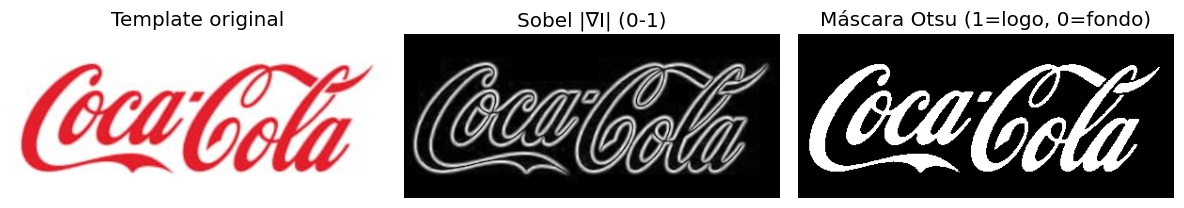

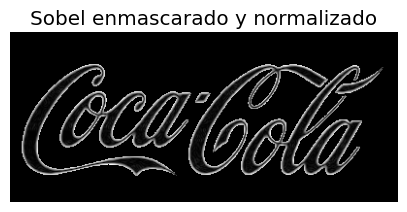

In [56]:
# Mostrar template original, Sobel y máscara
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(bgr2rgb(tpl_bgr))
plt.title("Template original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(tpl_sobel, cmap='gray')
plt.title("Sobel |∇I| (0-1)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(tpl_mask, cmap='gray')
plt.title("Máscara Otsu (1=logo, 0=fondo)")
plt.axis("off")

plt.tight_layout()
plt.show()

# Mostrar Sobel enmascarado y normalizado
plt.figure(figsize=(5,5))
plt.imshow(tpl_norm, cmap='gray')
plt.title("Sobel enmascarado y normalizado")
plt.axis("off")
plt.show()

In [57]:
image_files = sorted(glob.glob(os.path.join(images_path, '*.png')) +
                     glob.glob(os.path.join(images_path, '*.jpg')))

preproc = {}  # nombre -> sobel (float32 [0,1])
for p in image_files:
    img = cv.imread(p)
    if img is None: 
        continue
    sob = preprocess_gray_to_sobel(img)
    preproc[os.path.basename(p)] = {
        "sobel": sob,
        "shape": sob.shape
    }

print(f"Template sobel: {tpl_norm.shape}, imágenes preprocesadas: {len(preproc)}")

Template sobel: (175, 400), imágenes preprocesadas: 7


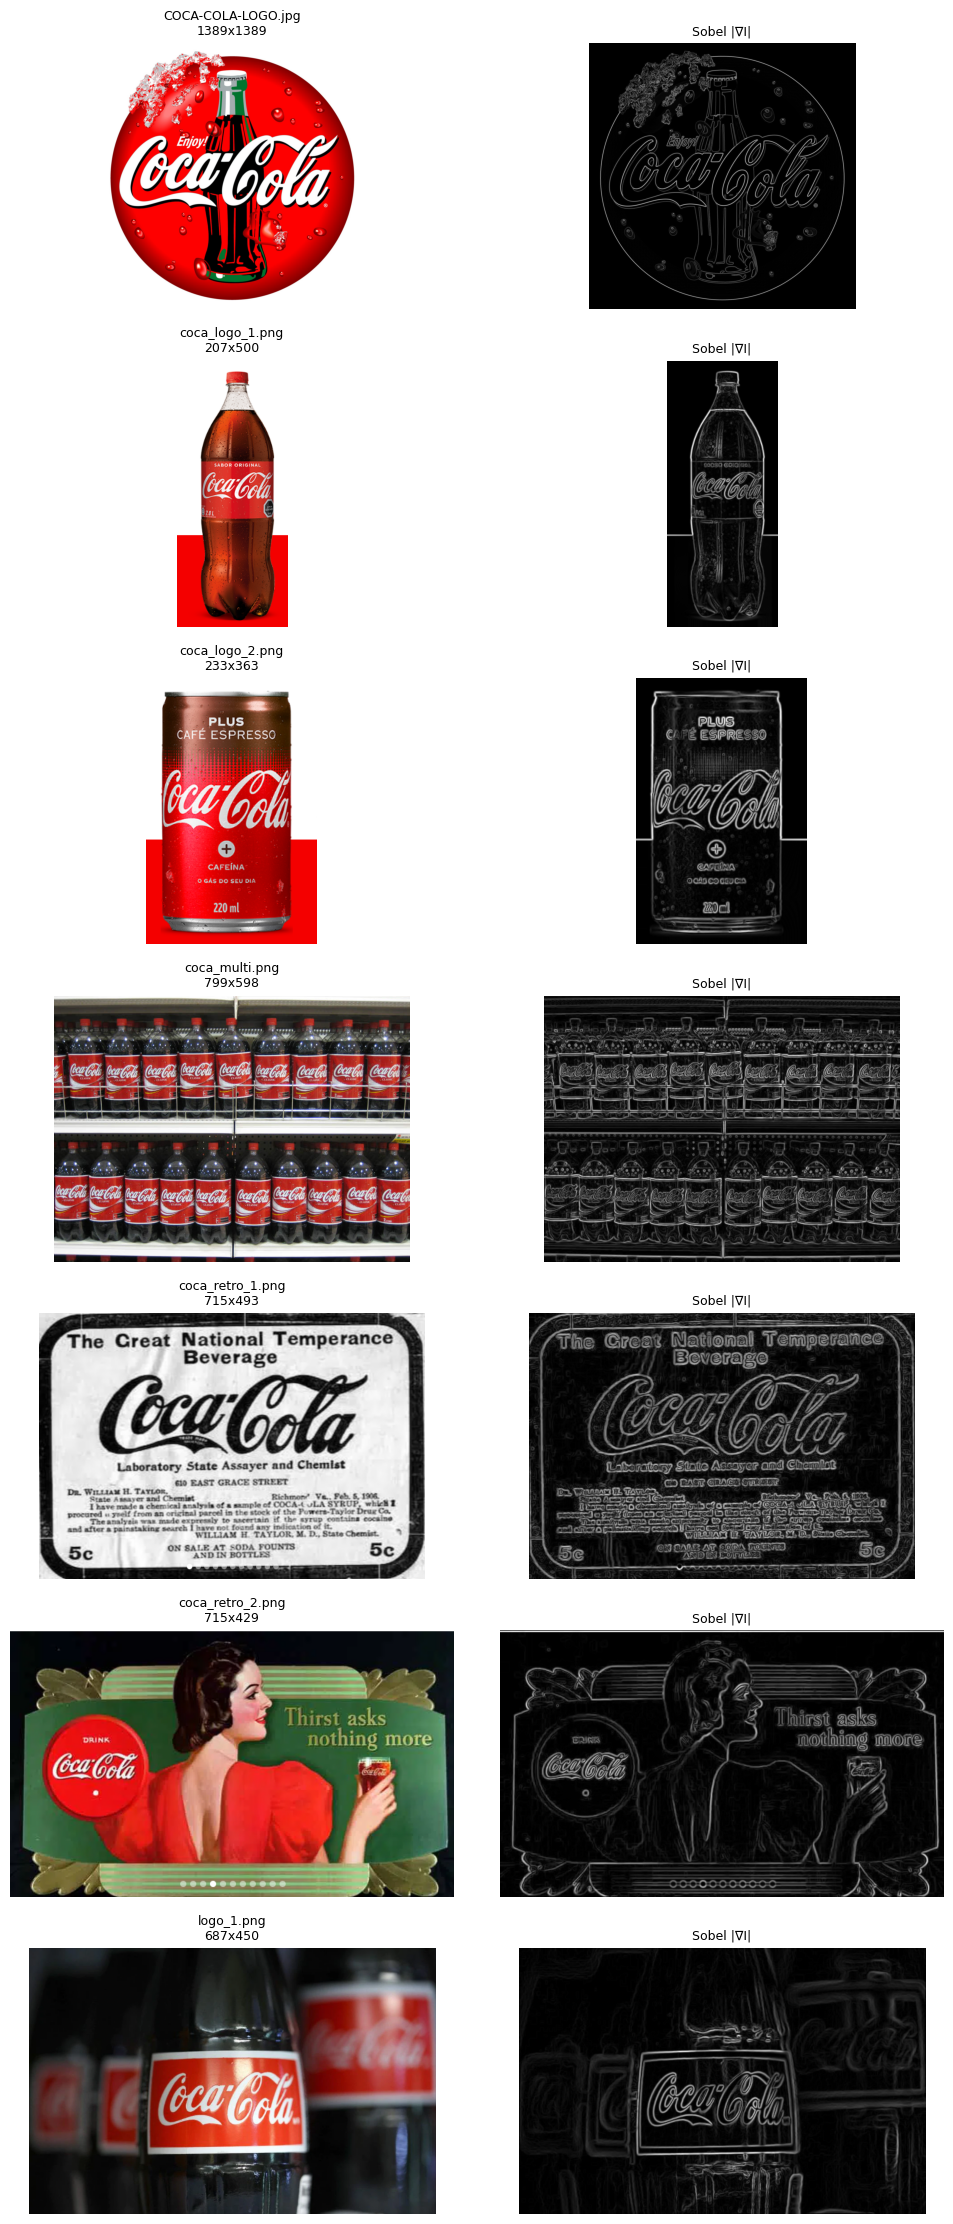

In [58]:
names = list(preproc.keys())
n = len(names)
rows, cols = n, 2

plt.figure(figsize=(10, 3.2*rows))

for i, name in enumerate(names, start=0):
    # Original
    img_bgr = cv.imread(os.path.join(images_path, name))
    img_rgb = bgr2rgb(img_bgr)

    # Sobel (preprocesado que ya calculaste)
    sob = preproc[name]["sobel"]

    # Columna 1: original
    ax1 = plt.subplot(rows, cols, 2*i + 1)
    ax1.imshow(img_rgb)
    h, w = preproc[name]["shape"]
    ax1.set_title(f"{name}\n{w}x{h}", fontsize=9)
    ax1.axis('off')

    # Columna 2: sobel
    ax2 = plt.subplot(rows, cols, 2*i + 2)
    ax2.imshow(sob, cmap='gray')
    ax2.set_title("Sobel |∇I|", fontsize=9)
    ax2.axis('off')

plt.tight_layout()
plt.show()

### Template Matching

In [96]:
def nms(boxes, scores, iou_thr=0.5):
    if not boxes: return []
    boxes  = np.array(boxes, dtype=np.float32)
    scores = np.array(scores, dtype=np.float32)
    order  = scores.argsort()[::-1]
    keep = []
    while len(order) > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(boxes[i,0], boxes[order[1:],0])
        yy1 = np.maximum(boxes[i,1], boxes[order[1:],1])
        xx2 = np.minimum(boxes[i,2], boxes[order[1:],2])
        yy2 = np.minimum(boxes[i,3], boxes[order[1:],3])
        w = np.maximum(0.0, xx2-xx1+1); h = np.maximum(0.0, yy2-yy1+1)
        inter = w*h
        area_i = (boxes[i,2]-boxes[i,0]+1)*(boxes[i,3]-boxes[i,1]+1)
        area_o = (boxes[order[1:],2]-boxes[order[1:],0]+1)*(boxes[order[1:],3]-boxes[order[1:],1]+1)
        iou = inter/(area_i+area_o-inter+1e-9)
        order = order[1:][iou <= iou_thr]
    return keep

def find_local_peaks_adaptive(res_map, base_thr=0.5, k=2.0, min_dist=10, max_peaks=80):
    mu, sigma = float(res_map.mean()), float(res_map.std())
    thr = max(base_thr, mu + k*sigma); thr = min(thr, 0.95)
    kernel = np.ones((3,3), np.uint8)
    maxima = cv.dilate(res_map, kernel)
    peak = (res_map == maxima) & (res_map >= thr)
    ys, xs = np.where(peak)
    if len(xs) == 0: return []
    sc = res_map[ys, xs]
    ord_idx = np.argsort(-sc); xs, ys, sc = xs[ord_idx], ys[ord_idx], sc[ord_idx]
    selx, sely, sels = [], [], []
    md2 = min_dist**2
    for x,y,s in zip(xs, ys, sc):
        if all((x-px)**2 + (y-py)**2 >= md2 for px,py in zip(selx,sely)):
            selx.append(int(x)); sely.append(int(y)); sels.append(float(s))
        if len(selx) >= max_peaks: break
    return list(zip(selx, sely, sels))

def passes_geometry(x1,y1,x2,y2, tpl_ratio, tol=0.15):
    w = (x2-x1+1); h = (y2-y1+1)
    ratio = w / max(h,1)
    return abs(ratio - tpl_ratio) / tpl_ratio <= tol

def edge_coverage_ok(patch, tpl_mask_resized, cov_thr=0.30):
    p = patch.astype(np.float32)
    p = (p - p.min()) / (p.ptp() + 1e-6)
    strong = (p > 0.35).astype(np.uint8)
    inter = (strong & (tpl_mask_resized>0)).sum()
    denom = max((tpl_mask_resized>0).sum(), 1)
    return (inter/denom) >= cov_thr

def build_image_pyramid(im, n_down=6, min_side=32):
    pyr = [im]
    for _ in range(n_down):
        last = pyr[-1]
        if min(last.shape[:2]) < min_side: break
        pyr.append(cv.pyrDown(last))
    return pyr

def pyr_up_im(im, n_up=0, max_side=4000):
    up = im
    for _ in range(n_up):
        if max(up.shape[:2]) > max_side: break
        up = cv.pyrUp(up)
    return up

def multiscale_match_pyramid(img_sobel, tpl_sobel, tpl_mask,
                             n_down=6, n_up=1,
                             base_thr=0.5, k=2.0,
                             iou_thr=0.55, geom_tol=0.15, cov_thr=0.35,
                             max_peaks_per_level=80):
    """
    Multi-escala sin fracciones: pirámide de la IMAGEN (down/up), template fijo.
    """
    # normalización
    im = img_sobel.astype(np.float32);  im /= (255.0 if im.max()>1.5 else 1.0)
    tp = tpl_sobel.astype(np.float32);  tp /= (255.0 if tp.max()>1.5 else 1.0)
    msk = (tpl_mask>0).astype(np.uint8)

    tH, tW = tp.shape[:2]
    tpl_ratio = tW / max(tH,1)

    boxes_all, scores_all = [], []

    # --- UP (para logos muy chicos en la original) ---
    if n_up > 0:
        im_up = pyr_up_im(im, n_up)
        for u in range(n_up, 0, -1):
            lvl = im_up
            scale_back = 1.0 / (2**u)
            if tH < lvl.shape[0] and tW < lvl.shape[1]:
                res = cv.matchTemplate(lvl, tp, cv.TM_CCORR_NORMED, mask=msk)
                min_dist = max(6, int(min(tW,tH)*0.4))
                peaks = find_local_peaks_adaptive(res, base_thr=base_thr, k=k,
                                                  min_dist=min_dist, max_peaks=max_peaks_per_level)
                for (x, y, sc) in peaks:
                    x1, y1 = int(x), int(y)
                    x2, y2 = x1 + tW, y1 + tH
                    if x2>lvl.shape[1] or y2>lvl.shape[0]: continue
                    patch = lvl[y1:y2, x1:x2]
                    if not passes_geometry(x1, y1, x2-1, y2-1, tpl_ratio, tol=geom_tol): continue
                    if not edge_coverage_ok(patch, msk, cov_thr=cov_thr): continue
                    X1 = int(round(x1 * scale_back)); Y1 = int(round(y1 * scale_back))
                    X2 = int(round((x2-1) * scale_back)); Y2 = int(round((y2-1) * scale_back))
                    boxes_all.append([X1,Y1,X2,Y2]); scores_all.append(float(sc))
            im_up = cv.pyrDown(im_up)

    # --- DOWN (para logos grandes) ---
    pyr = build_image_pyramid(im, n_down=n_down, min_side=32)
    for level, lvl in enumerate(pyr):  # 0 = original, 1 = 1/2, etc.
        scale_back = (2**level)
        if tH >= lvl.shape[0] or tW >= lvl.shape[1]: continue
        res = cv.matchTemplate(lvl, tp, cv.TM_CCORR_NORMED, mask=msk)
        min_dist = max(6, int(min(tW,tH)*0.4))
        peaks = find_local_peaks_adaptive(res, base_thr=base_thr, k=k,
                                          min_dist=min_dist, max_peaks=max_peaks_per_level)
        for (x, y, sc) in peaks:
            x1, y1 = int(x), int(y)
            x2, y2 = x1 + tW, y1 + tH
            if x2>lvl.shape[1] or y2>lvl.shape[0]: continue
            patch = lvl[y1:y2, x1:x2]
            if not passes_geometry(x1, y1, x2-1, y2-1, tpl_ratio, tol=geom_tol): continue
            if not edge_coverage_ok(patch, msk, cov_thr=cov_thr): continue
            X1 = int(round(x1 * scale_back)); Y1 = int(round(y1 * scale_back))
            X2 = int(round((x2-1) * scale_back)); Y2 = int(round((y2-1) * scale_back))
            boxes_all.append([X1,Y1,X2,Y2]); scores_all.append(float(sc))

    keep = nms(boxes_all, scores_all, iou_thr=iou_thr)
    return [boxes_all[i] for i in keep], [scores_all[i] for i in keep]

In [101]:
# tpl_sobel y tpl_mask ya los preparaste con tu pipeline (Gray->CLAHE->Blur->Sobel, Otsu para mask)
results = {}
for name, item in preproc.items():
    img_sobel = item["sobel"]  # uint8 [0..255]
    # img_sobel: tu preproc (gray -> clahe -> blur -> sobel)
    boxes, scores = multiscale_match_pyramid(
        img_sobel, tpl_sobel, tpl_mask,
        n_down=6,  # más niveles hacia abajo = mejor para logos grandes
        n_up=1,    # 0–2 según cuán chico pueda ser el logo
        base_thr=0.5, k=2.0,
        iou_thr=0.60, geom_tol=0.15, cov_thr=0.35
    )
    results[name] = {"boxes": boxes, "scores": scores}
    print(f"{name}: {len(boxes)} detecciones")

COCA-COLA-LOGO.jpg: 0 detecciones
coca_logo_1.png: 0 detecciones
coca_logo_2.png: 1 detecciones
coca_multi.png: 0 detecciones
coca_retro_1.png: 10 detecciones
coca_retro_2.png: 1 detecciones
logo_1.png: 0 detecciones
coca_retro_1.png: 10 detecciones
coca_retro_2.png: 1 detecciones
logo_1.png: 0 detecciones


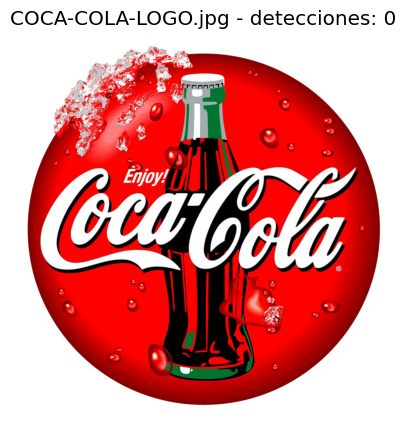

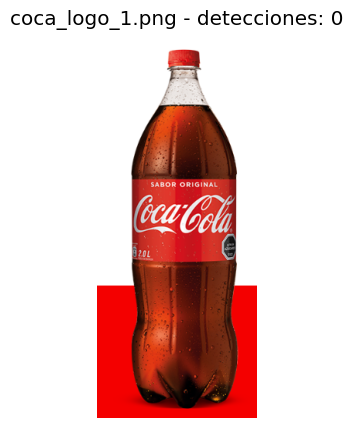

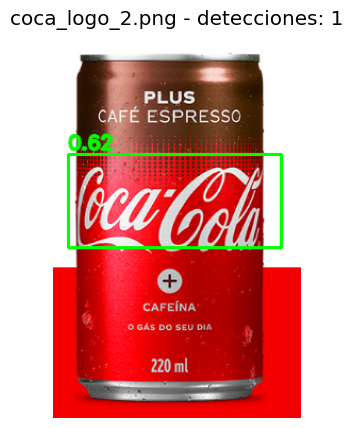

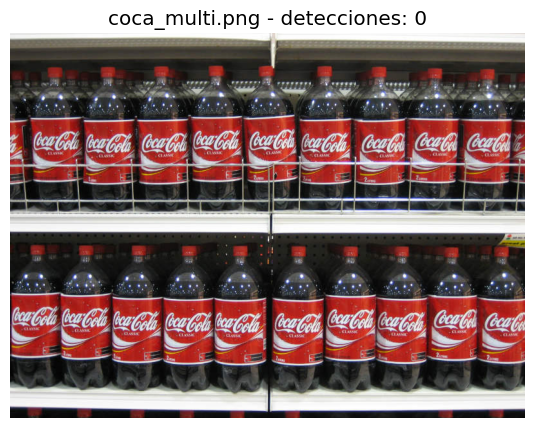

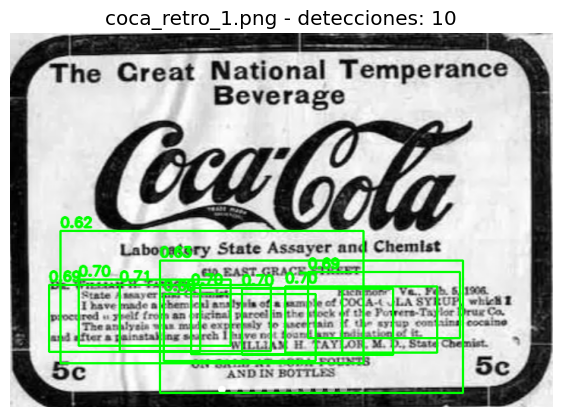

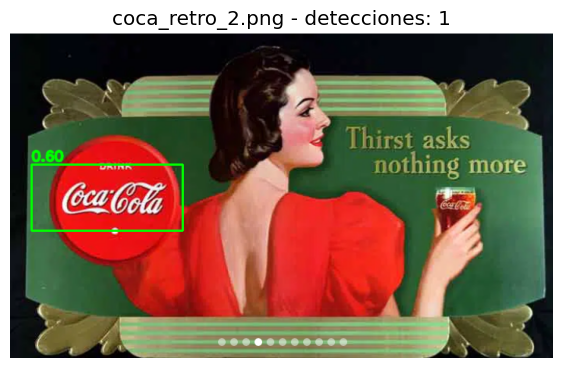

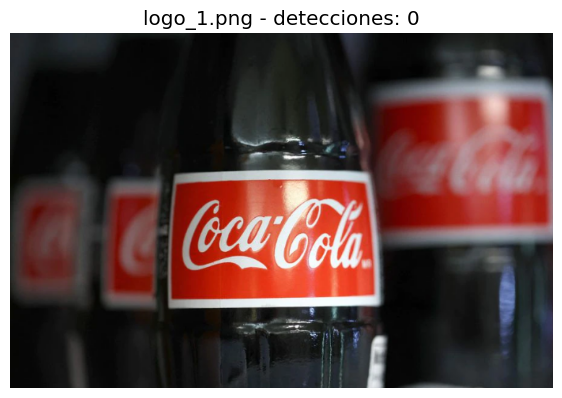

In [102]:
import matplotlib.pyplot as plt

def draw_detections(bgr, boxes, scores, color=(0,255,0)):
    out = bgr.copy()
    for (x1, y1, x2, y2), sc in zip(boxes, scores):
        cv.rectangle(out, (x1, y1), (x2, y2), color, 2)
        cv.putText(out, f"{sc:.2f}", (x1, max(0, y1-5)),
                   cv.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv.LINE_AA)
    return out

# Mostrar detecciones para cada imagen
for name, res in results.items():
    img_bgr = cv.imread(os.path.join(images_path, name))
    vis = draw_detections(img_bgr, res["boxes"], res["scores"])
    plt.figure(figsize=(7,5))
    plt.imshow(bgr2rgb(vis))
    plt.title(f"{name} - detecciones: {len(res['boxes'])}")
    plt.axis('off')
    plt.show()